In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

In [2]:
!gdown --id 1YeMbHLs3QcJurmbdpmtxGyFTQw0vDxST

Downloading...
From: https://drive.google.com/uc?id=1YeMbHLs3QcJurmbdpmtxGyFTQw0vDxST
To: /content/inno_stats.tar.gz
1.91GB [00:19, 99.8MB/s]


In [5]:
!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

mkdir: cannot create directory ‘data’: File exists


In [2]:
sheet_id = "1SIf2vawr2VWwme_6v_VZyHivJ502bWFN70SQLf-iBkM"
sheet_name = "bad_ids.csv"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

bad_ids = pd.read_csv(url)

In [3]:
bad_ids.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


In [4]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv  10_groups.csv  11_groups.csv  product_groups.csv


In [5]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [6]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


## Preprocessing

In [7]:
bad_ids_set = set(bad_ids['id_card'])
df = g_9[~g_9['id_card'].isin(bad_ids_set)]

## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

H0 - there is no dependency

In [8]:
total = df[['sum', 'id_doc']].groupby("id_doc").sum()['sum'].to_list()

total_discounts = df[['id_doc', 'is_green']].groupby("id_doc")['is_green'].sum().to_list()
order_n = df[['sum', 'id_doc']].groupby("id_doc").count()['sum'].to_list()

discount_percent = np.array(total_discounts)/np.array(order_n)

In [9]:
from scipy.stats import ttest_ind

test1 = ttest_ind(total, discount_percent)
test1

Ttest_indResult(statistic=2494.836117020941, pvalue=0.0)

P-value = 0, reject H0. There is a dependency. Proved

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

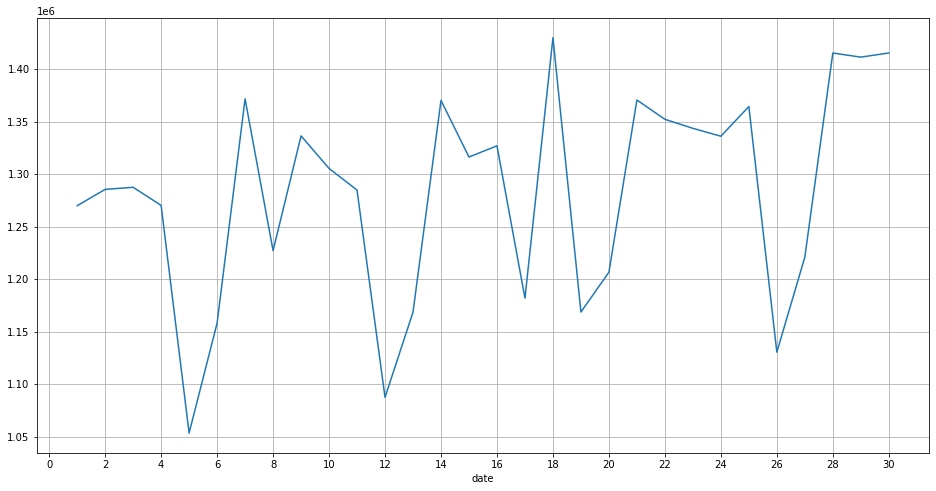

In [10]:
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
number_of_purchases = df.groupby(df.index.day)['id_order'].count()

plt.figure(figsize=(16, 8))
plt.locator_params(axis="x", nbins=20)
number_of_purchases.plot()
plt.grid()

We can see the growth of number of purchases starting from the 5th of the month, and starting from the 20th. Proved

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

Frequent buyers

In [12]:
frequent_buyers = df.groupby(by=['id_doc'])
frequent_buyers.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
date,,,,,,,,,,
2020-09-01 17:01:25,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
2020-09-01 17:35:36,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2020-09-01 19:19:21,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
2020-09-01 21:53:34,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
2020-09-01 18:42:31,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
...,...,...,...,...,...,...,...,...,...,...
2020-09-30 11:26:28,2020-09-30 11:26:28,4850561,0.0,1739990,25292,17528,1.0,130.00,0,10099
2020-09-30 08:12:39,2020-09-30 08:12:39,10015419,0.0,1761351,30740,19188,2.0,120.00,0,10008
2020-09-30 09:54:24,2020-09-30 09:54:24,22816791,0.0,1432778,30741,19188,1.0,73.00,0,10254


Average purchase sum

Sorry, from now on by RAM is dead in Colab, so I have no ability to check the solution :(

In [ ]:
grouped_df = df.groupby('id_card')['sum'].std()
grouped_df = grouped_df[grouped_df < 500]

plt.figure(figsize=(10, 5))
plt.xlabel('Sum of standard deviations')
plt.ylabel('Count')
plt.hist(grouped_df, bins=20);

Orders amount

In [ ]:
grouped_by_user = df.groupby('id_card')
number_of_orders_per_user = grouped_by_user.agg({"id_doc": "nunique"})
number_of_orders_per_user.head()
grouped_by_number_of_orders = number_of_orders_per_user.groupby('id_doc')
grouped_by_number_of_orders.groups

Usual cart

In [ ]:
group2num_customers = df.groupby('id_group')['id_card'].unique().apply(len)
group2num_customers.sort_values().plot(kind='bar')
plt.ylabel('Count');